<a href="https://colab.research.google.com/github/strongway/tutorial_data_science/blob/master/lecture_2022/RT_analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# RT analysis with R

Zhuanghua Shi (Nov. 2022)

This is a quick tutorial on RT analysis. It won't cover the basic R language or the tidyverse style of coding. Please learn R on DataCamp. 

Here I illustrate the basic procedure of RT analysis with one real dataset. 

## Study: Pop out visual search with discrimination task

In this case study, we have one full data set from a visual search experiment (Allenmark et al., 2018), in which participants had to discriminate a colour or orientation pop-out target. A typical search display is shown in the following figure (an orientation target, tiled left or right). If it was a colour target, the target was either green or red. 

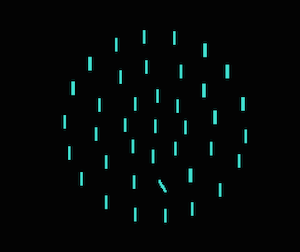

In this experiment, the proportion of color target vs. orientation systematically varied across three sections: 75% vs. 25%, 50% vs. 50%, 25% vs. 75%.   The task was to report as quickly and accurately as possible whether a target was color or orientation, using the left and right mouse buttons, respectively. Each trial started with the presentation of a fixation dot for 700–900 ms followed by the stimulus display, which was displayed until the participant made a response. 

There were three sections, each consisting of 10 blocks of 40 trials. Twelve participants took part in this experiment. All had normal or corrected-to-normal vision and were naive as to the purpose of the experiment. All participants gave informed consent before the experiment. 

The research questions we had in mind are: 

1. How does the target ratio (color vs. orientation) in one block influence search performance? 
2. Does target ratio interact with the target dimension (color/orientation)?
3. How does the target appeared in a previous trial influence on target detection in the current trial?


## Data structure

All data were pooled together and stored in a R-binary format file (`exp1.rds`).  Experimental data are usually stored in Matlab, excel, or text formats. You can read them into R using different packages. For examples, using `readMat()` from `R.matlab` package for importing Matlab `.mat` files; `read.csv` for reading csv files. 


In [1]:
# we need to install RWiener package for DDM analysis
install.packages("RWiener")

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)



In [7]:
library(tidyverse)
library(RWiener)


Warning message in system("timedatectl", intern = TRUE):
“running command 'timedatectl' had status 1”
── Attaching packages ─────────────────────────────────────── tidyverse 1.3.1 ──

✔ ggplot2 3.4.0      ✔ purrr   0.3.5 
✔ tibble  3.1.8      ✔ dplyr   1.0.10
✔ tidyr   1.2.1      ✔ stringr 1.4.1 
✔ readr   2.1.3      ✔ forcats 0.5.2 

── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()



In [5]:
raw = readRDS(url("https://github.com/msenselab/ite-bayesian-updating/blob/master/data/exp1.rds?raw=true"),'rb')
head(raw)

,target,BlkType,dimension,color,orientation,position,response,rt,rs,blkNo,sub,outlier,error,tno
,<fct>,<ord>,<fct>,<fct>,<fct>,<dbl>,<dbl>,<dbl>,<dbl>,<int>,<fct>,<lgl>,<lgl>,<int>
1,Absent,1:3,Orientation,turg,right,0,1,1.5195193,0.6581029,1,aleg,TRUE,FALSE,1
2,Absent,1:3,Orientation,red,left,0,1,0.7434531,1.3450748,1,aleg,FALSE,FALSE,2
3,Absent,1:3,Orientation,red,right,0,1,0.7329646,1.3643224,1,aleg,FALSE,FALSE,3
4,Absent,1:3,Orientation,red,right,0,1,0.6048289,1.6533601,1,aleg,FALSE,FALSE,4
5,Absent,1:3,Orientation,red,right,0,1,0.6154432,1.6248453,1,aleg,FALSE,FALSE,5
6,Absent,1:3,Orientation,turg,left,0,1,0.4685663,2.1341696,1,aleg,FALSE,FALSE,6


Using `head(varTable)` you can show the structure and data (header) from a table. The above shows us that the raw data have 13 columns with 14400 observations (trials). The variable is also listed on the right side of your Rstudio, where you can open the table by double clicking the variable. 

<span style='color:blue'>__Your task:__ open the table and inspect the table, and see if you can guess meanings from the column names.</span> 

In most cases behavioural raw data store detailed information, which has more information than we want. Here the most relevant columns we will focus on  are: 

1. Dimension: defining target property
2. BlkType: types of block, color:orientation ratio of targets
3. rt: reaction time (in seconds)
4. sub: subject number
5. error: error response
6. outlier: outliers based on the RTs and the first trial of each block. You can also calculate outliers yourself. 

<span style='color:blue'>__Question:__ What outlier criteria should we set for a normal response time experiment?</span>

### Step 1: Error Analysis


The first step of data analysis is to remove those error trials. However, before doing this, we must make sure there is no speed-accuracy trade-off. 

<span style='color:blue'>__Question:__ Why should we care about the speed-accuracy trade-off (SATO)?</span>



Your answer:

###

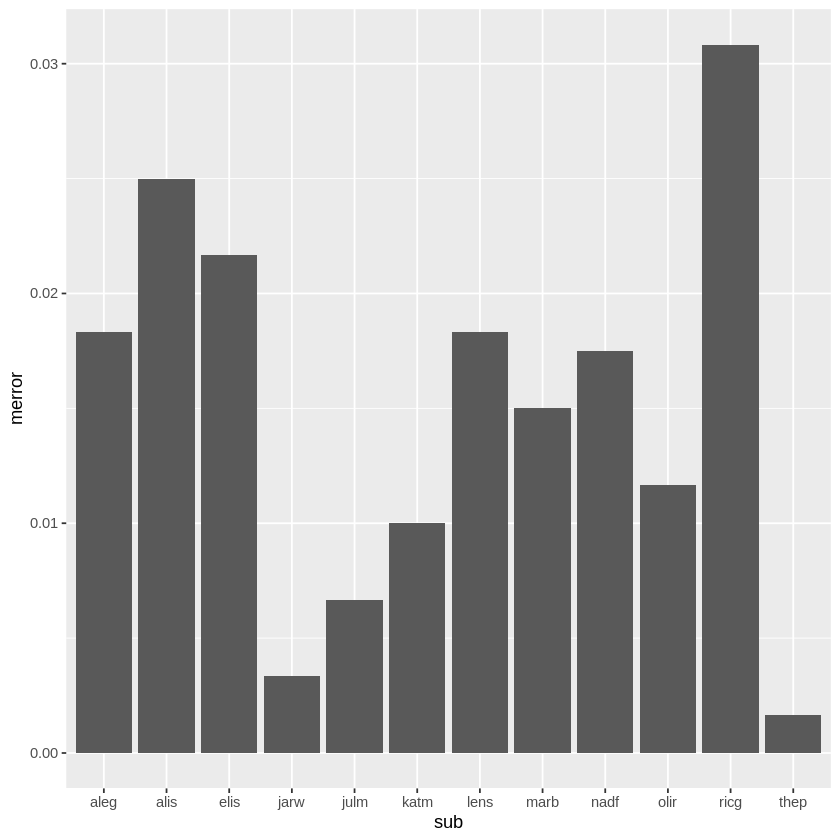

In [8]:
# check individual error rates

raw %>% group_by(sub) %>% # separate for each participant
  summarise(merror = mean(error)) %>% # calculate mean error
  ggplot(aes(x=sub, y = merror)) + geom_bar(stat = 'identity') # visualize with bar plot


Now we turn to speed-accuracy trade-off analysis: we compare the RTs from the correct trials to incorrect trials. If the incorrect trials had faster responses, there must be some speed-accuracy trade-off. 


`summarise()` has grouped output by 'sub'. You can override using the `.groups`
argument.


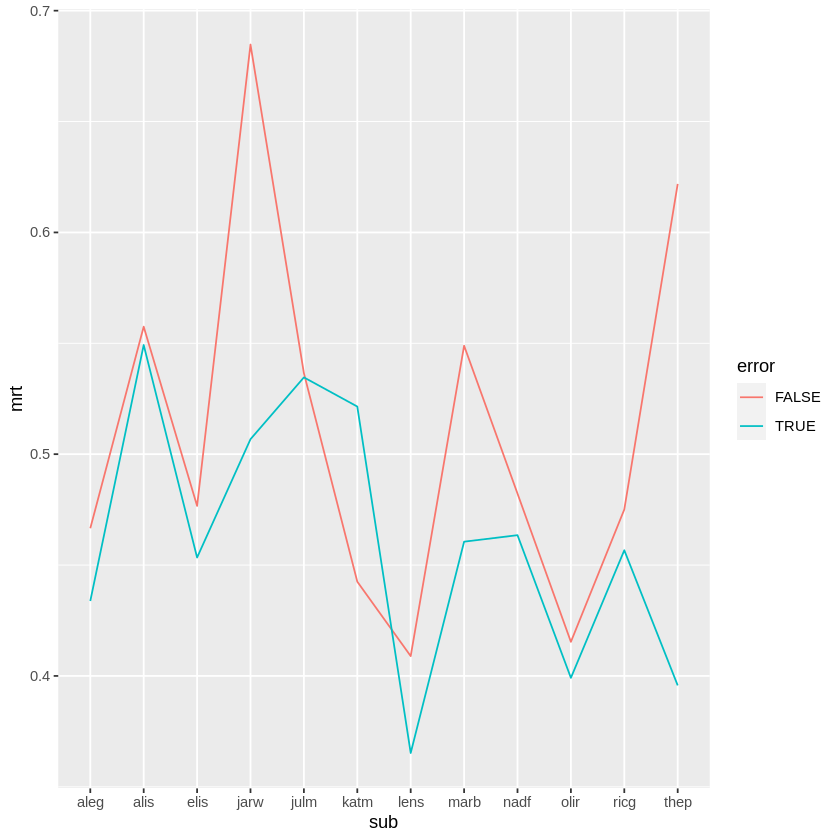

In [9]:
raw %>% filter(outlier == FALSE) %>%
  group_by(sub, error) %>%
  summarise(mrt = mean(rt)) %>% 
  ggplot(aes(x=sub, y = mrt, group= error, color = error)) + geom_line()


By visual inspection, the error trials look like to have faster responses. This may indicate certain degree of speed-accuracy trade-off. However, this needs further statistical tests. Note that, if the SATOs occur equally in all conditions, SATOs would not affect our conclusions given that we use within-subject full-factorial design. Thus, it is important to do statistical tests on the RTs, and, if necessary, do error analysis across different experimental conditions. 

One simple package for doing ANOVA analysis is the `ez` package. If you haven't installed this package, install this package first. Several main parameters of the ezANOVA are:

1. dv - dependent variable
2. wid - random variable. For within-subject design, we often put subject No. as random variable. 
3. within - within-subject factors
4. between - between-subject factors

If you have more than one within- or betwee-factors, you need to use operator `.()` to combine them. For example, if we want to test two within-subject factors `dimension` and `ratio`, we need to specify `within = .(dimension, ration)`. 

Due to install ez in colab takes a lot of other packages. I will not demonstrate this here. You can use your local R to run this using RStudio. 

```
   library(ez)
    av1 = ezANOVA(raw %>% filter(outlier == FALSE),
         dv = rt,
         wid = sub, 
         within = error) #within factors
   kable(av1$ANOVA)
```

Based on the statistical test we can say no significant evidence of SATO for general discrimination task. But to be sure, we need to further do a condition-wise SATO analysis. Note the difference in the parameter `within=`. 


## Mean RTs

Given that there is NO SATO, we will remove those error trials for the future analysis. First we calculate mean RT data from the valid trials.

In [11]:
vdata = raw %>% filter(!outlier & !error) # filter outliers and errors
# accomplish the following codes

mrts = vdata %>% group_by(sub, BlkType, dimension) %>%
     summarise(mrt = mean(rt))

`summarise()` has grouped output by 'sub', 'BlkType'. You can override using
the `.groups` argument.


With the mean RTs, we can now visualise them using ggplot. Please inspect the code, and let me know if you understand this. 

`summarise()` has grouped output by 'BlkType'. You can override using the
`.groups` argument.


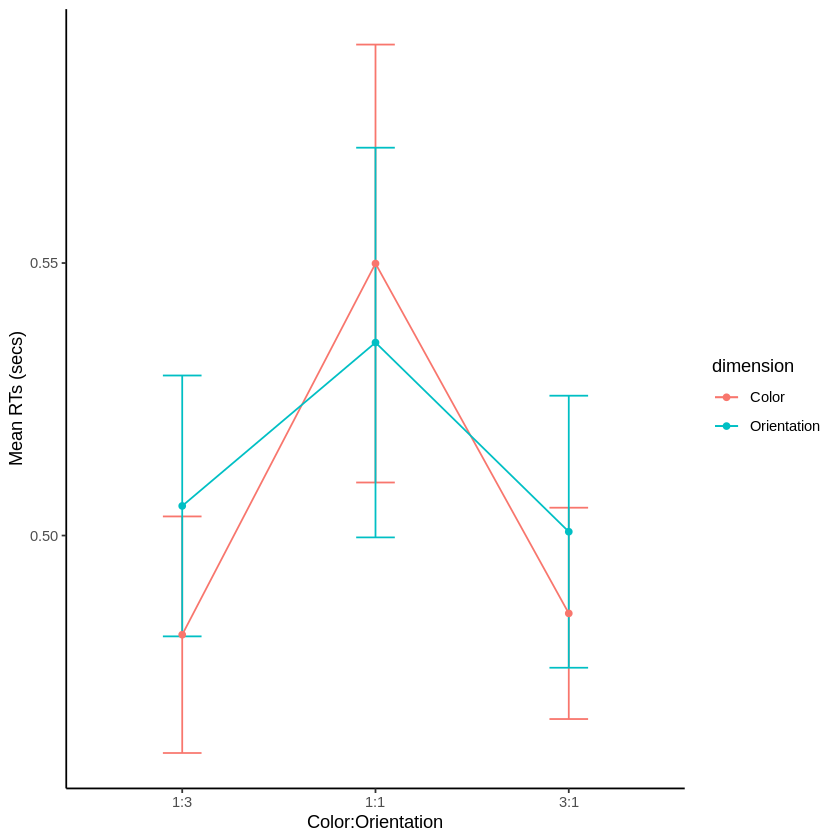

In [12]:
# first collapse data across participants
gmrt = mrts %>% group_by(BlkType, dimension) %>%
  summarise(rt = mean(mrt), 
            n = n(), 
            se = sd(mrt)/sqrt(n-1)) 
# now visualize the grant mean rt
gmrt %>%  ggplot( aes(x = BlkType, y = rt, group = dimension, color = dimension)) + 
  geom_line() + # line plot
  geom_errorbar(aes(ymin = rt - se, ymax = rt + se), width = 0.2) +
  geom_point() + 
  xlab('Color:Orientation') + 
  ylab('Mean RTs (secs)') + 
  theme_classic()

<span style='color:blue'>__Question:__ Why should we first average mean RTs for each individual participants, and then pool together again for second averaging? Can we do in one step?</span>

The above pattern certainly shows the interaction, when the frequency of the target (e.g., dimension) is lower, the mean RT is slower. But we want to have an analysis on the frequency of each dimension. Thus we need to create a new column based on `BlkType`. 

Let's first show the `BlkType`

In [13]:
print(unique(mrts$BlkType))
print(as.numeric(unique(mrts$BlkType)))

[1] 1:3 1:1 3:1
Levels: 1:3 < 1:1 < 3:1
[1] 1 2 3


It is an ordinal factor variable, encoding color:orientation with three levels. We can use `as.numeric()` to convert it to numeric. Now we recode the `BlkType` to `frequency`. 

In [15]:
mrts %>% mutate(frequency = as.numeric(dimension) -1 +
                  (-1)^(as.numeric(dimension)-1)*0.25 * 
                  as.numeric(BlkType) ) -> mrts
head(mrts)

sub,BlkType,dimension,mrt,frequency
<fct>,<ord>,<fct>,<dbl>,<dbl>
aleg,1:3,Color,0.4448916,0.25
aleg,1:3,Orientation,0.4746788,0.75
aleg,1:1,Color,0.4721115,0.50
aleg,1:1,Orientation,0.4830419,0.50
aleg,3:1,Color,0.4582244,0.75
aleg,3:1,Orientation,0.4660163,0.25


<span style='color:blue'>__Your task:__ please replot the mean RT figure with `frequency` as x-axis, and dimension as separate line.</span> 

In [ ]:
```{r mrt_plot2, out.width= '50%'}
# Your code here

```


In the final step, you should run a repeated-measures ANOVA using `ezANOVA`. We skip this here. 

## RT distributions

Let's first visualize the RTs with historgram.


`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.


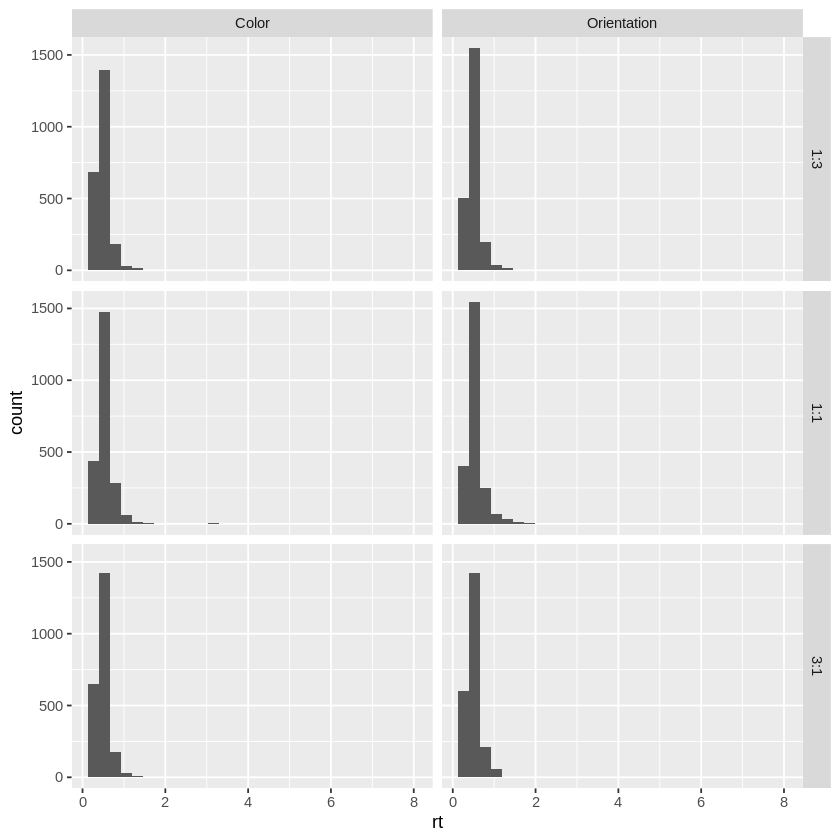

In [10]:
raw %>% filter(!outlier  & !error) %>%
  group_by(dimension, BlkType) %>%
  ggplot(aes(x=rt)) + geom_histogram() + facet_grid(BlkType~dimension)


 This kind of distribution can be predicted by the drift-diffusion model (DDM). 


Let's get familiar with the `RWiener` package. 

### 1. Generate random RT dataset. 

We use `rwiener` to generate 100 samples with boundary separation of 2, non-decision time 0.3 second, initial unbias (0.5) and drift rate of 0.5. The returned data is a table with responses (`resp`) either 'upper' or 'lower' (2AFC) and RTs (`q`). Then, we use `dwiener` to visualize the density function. 

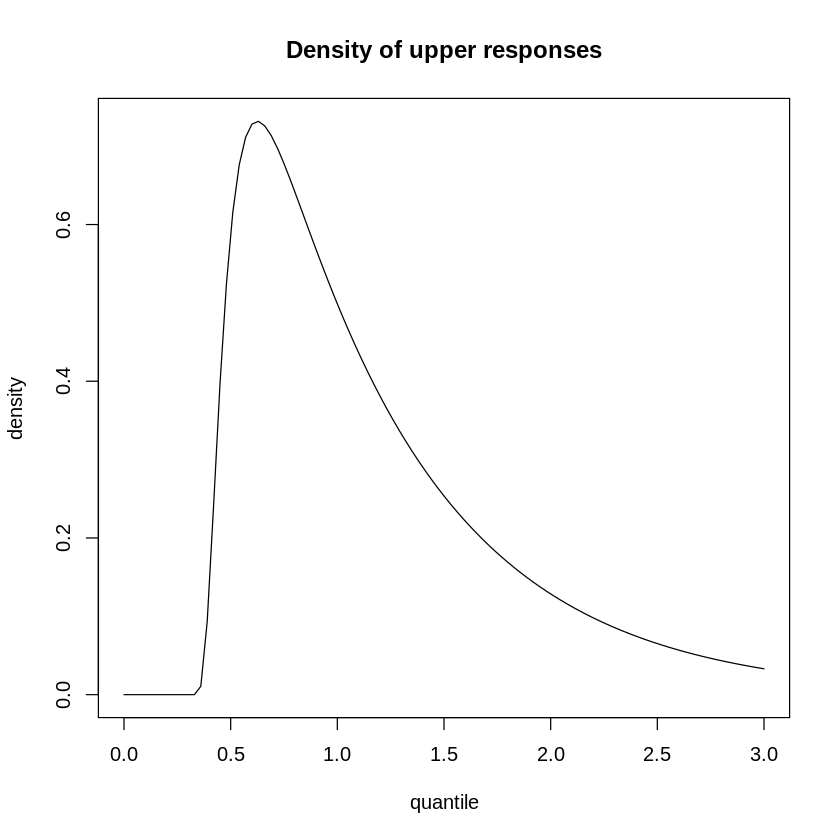

In [3]:
library(RWiener)
# randomly generate the RT data
dat = rwiener(n = 100, alpha = 2, tau = 0.3, beta = .5, delta = .5)
# visualize the density function
curve(dwiener(x, 2, .3, .5, .5, rep("upper", length(x))),
      xlim=c(0,3), main="Density of upper responses",
      ylab="density", xlab="quantile")

r we can easily visualize from the data by using `wiener_plot`. 

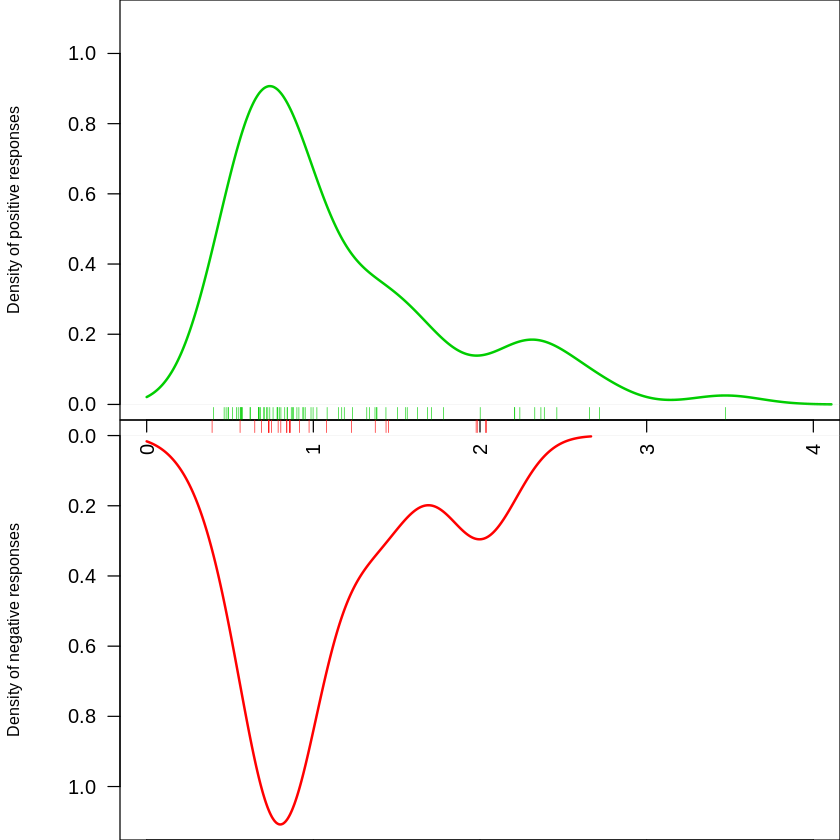

In [16]:
wiener_plot(dat)

### 2. Estimating DDM parameters

In the above section, we __specify__ parameters and simulate RT data. In reality, we need to estimate the parameters of the DDM. This can be done by using R's optim function, in which we need to specify the initial guess parameter ($\alpha, \tau, \beta, \delta$), `wiener_deviance` and data table. 

In [17]:
# estimate parameters
est = optim(c(1,0.1,0.1,1), wiener_deviance, dat = dat)
# show parameters (true values: 2, 0.3, 0.5, 0.5)
est$par
# Note the new version use wdm function.

[1] 1.9060210 0.3064126 0.4986842 0.5616849

### 3. Applying to our data

Note that, the upper and lower are two possible responses during a drift-diffusion process. Here we use 'color' for the upper bound and the 'orientation' for the lower bound. This also means that the rate is not purely information intaking, rather the ratio of the information intaking speed. Alternatively, one can use 'error' and 'correct' for the lower and upper bound. Doing this you will get absolute information intaking speed, but this requires a certain amount of error trials. Otherwise, it is hard to find the lower boundary. 

Let's first estimate one condition from one participant. 

In [18]:
# select subject data
raw %>% filter(!outlier & !error & BlkType == '3:1' & sub =='aleg') %>% 
  mutate(resp = ifelse(dimension=='Color', 'upper','lower'), 
         q = rt) %>% # add upper, lower
  select(q,resp) -> sub1

# find parameter
optim(c(2,.1,.5,0.3), wiener_deviance, dat = sub1) -> est
# print estimated parameter
est$par

[1]  0.86042718  0.28737089  0.50324724 -0.02902411

Let's estimate parameters for all conditions. 

In [20]:
# we need a function for estimating parameter
estPar <- function(df){
  est = optim(c(2,0.1,0.5,0.3), wiener_deviance, dat = data.frame(df))
  data.frame(a = est$par[1], tau =est$par[2], beta = est$par[3], delta = est$par[4]  ) # return parameter
}

# subsecting data, estimate parameter, then combine all parameters together
raw %>% filter(!outlier & !error & sub =='aleg'  ) %>%
  mutate(resp = ifelse(dimension == 'Color', 'upper','lower'), q = rt) %>%
  select(q, resp, BlkType, sub) %>%
  group_by(sub, BlkType) %>% nest() %>%
  mutate(par = data %>% map(estPar)) %>% 
  select(sub, BlkType, par) %>%
  unnest() -> exp1_pars
head(exp1_pars)

Warning message:
“`cols` is now required when using unnest().
Please use `cols = c(par)`”


sub,BlkType,a,tau,beta,delta
<fct>,<ord>,<dbl>,<dbl>,<dbl>,<dbl>
aleg,1:3,0.8994018,0.2773509,0.5607737,-0.31893022
aleg,1:1,0.8619231,0.3056783,0.5273349,-0.16305882
aleg,3:1,0.8604272,0.2873709,0.5032472,-0.02902411


Let's get the mean parameters out. 

In [21]:
exp1_pars %>% 
  group_by(BlkType) %>%
  summarise(a = mean(a), tau = mean(tau), beta = mean(beta), delta = mean(delta))

BlkType,a,tau,beta,delta
<ord>,<dbl>,<dbl>,<dbl>,<dbl>
1:3,0.8994018,0.2773509,0.5607737,-0.31893022
1:1,0.8619231,0.3056783,0.5273349,-0.16305882
3:1,0.8604272,0.2873709,0.5032472,-0.02902411


Roughly we can see the beta (bias) and delta (drift rate) were different from three conditions. It should be note the above estimation made no assumption of the underlying mechanisms, and did not compare to other alternative model, only say all parameters could be varied. 

To get a better picture of the underlying mechanisms, you need to compare to multiple alternativ models, e.g., fixing the draft rate but altering the bias, or fixed the bias altering the drift rate, and compare which one predicts better. 
For details, please see Allenmark et al. (2018). 

Allenmark, F., Shi, Z., Müller, H. J. (2018) Inter-trial effects in visual search: Factorial comparison of Bayesian updating models, PLOS Computational Biology, e1006328, doi:10.1371/journal.pcbi.1006328 
